## netCDF: Importing netCDF files, extracting desired data and bringing it into a desired format

In this file I will itterativly try to load and understand the structure of the by anemos delivered netCDF wind data.

1. I am going to install and load all the necessary packages to work with and analyse netCDF data

In [21]:
import xarray as xr
import timeit
import pandas as pd
import numpy as np
#import hvplot.xarray
import cartopy.crs as ccrs
import sys
def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'bytes'

import matplotlib.pyplot as plt

print(xr.__version__)

0.20.2


# 1. 10 minute data

Loading a netCDF file with the xarray package

In [22]:
#path = r"windData/wdirC.7L.2017-T.ts.nc"
year = 2017
nc_data_path = f"/uba/transfer/UBA-Windatlas/NC-Format/wspd.10L.{year}.nc"
tsnc_data_path = f"/uba/transfer/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

start = timeit.default_timer()

data = xr.open_dataset(nc_data_path, chunks={'time': 100}, engine='h5netcdf')
# for multiple files
#data = xr.open_mfdataset(nc_data_path, chunks={'time': 100}, parallel=True, engine='h5netcdf')

stop = timeit.default_timer()

print(f'Loadingtme for netCDF-file: {stop - start}')
size = format_bytes(sys.getsizeof(data))
print(f"Size of loaded file: {size}")
data

Loadingtme for netCDF-file: 0.28388507396448404
Size of loaded file: (112, 'bytes')


<xarray.Dataset>
Dimensions:  (y: 310, x: 225, time: 52560, level: 10)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(310, 225), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(310, 225), meta=np.ndarray>
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:50:00
  * x        (x) int16 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223 224
  * y        (y) int16 0 1 2 3 4 5 6 7 8 ... 301 302 303 304 305 306 307 308 309
  * level    (level) float32 40.0 60.0 80.0 100.0 ... 170.0 200.0 250.0 300.0
Data variables:
    wspd     (time, level, y, x) float32 dask.array<chunksize=(100, 10, 310, 225), meta=np.ndarray>
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2011-07-01_00:00:00
    SIMULATION_START_DATE:           2010-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Thu Aug  8 14:07:48 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

In [ ]:
type(data)

## Replace `x,y` Dimensions 

Initially the `x,y` dimensions of the netCDF file where ranging from 0 to the number of raw or column. The grid is structured as a *lambert projection*, but the absolut values of `0,...` do not represent the correct coordinates. Therefore,  anemos send us the correct lambert projection coordinates, in order to assign them to the `x,y` dimensions. 

With the result we should be able to transform a `lon,lat` coordinate *(EPSG=4326)* to a lambert projection coordinate.

In [27]:
# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"

new_dim_coor = pd.read_csv(path)

new_dim_coor["x"]

0     -369000.0
1     -366000.0
2     -363000.0
3     -360000.0
4     -357000.0
         ...   
305         NaN
306         NaN
307         NaN
308         NaN
309         NaN
Name: x, Length: 310, dtype: float64

In [42]:
# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

data = data.assign_coords(
    coords={"x": x,"y": y}
)


To implement netCDF-xarray visualization in later bokeh server applications, we will be using hvplot which builds on bokeh to plot our datasets in an interactive way. Different variations on geographic plots with hvplot can be found [online](https://hvplot.holoviz.org/user_guide/Geographic_Data.html).

In [ ]:
data2d = data.sel(time=f"{year}-03-29T19:30", level=120)
#data2d.to_array().plot(figsize=(10,12))
#data2d.hvplot.contourf(tiles='OSM', cmap='viridis').opts(width=500, height=500)
data2d.hvplot.quadmesh(
    x='lon', y='lat', 
    crs=ccrs.PlateCarree(), 
    projection=ccrs.PlateCarree(),
    cmap='viridis', 
    project=True, geo=True, rasterize=True, 
    coastline=True, 
    dynamic=False
    ).opts(width=500, height=500)

Defining Functions to get wspd (windspeed) at a given set of global coordinates, inside the local coordinate system, given by the anemos data.
Solution to filter lon, lat if they come as Data variables. ALL in numpy -> use numba to accelerate!

https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates

In [43]:
#[ 40.,  60.,  80., 100., 130., 160., 200., 250., 300.]
#@nb.vectorize(nopython=True)
def findPoint(xarray, Point):
    abslat = np.abs(xarray.lat-Point["coor"][0])
    abslon = np.abs(xarray.lon-Point["coor"][1])
    c = np.maximum(abslon, abslat)
    
    if 'level' in xarray.dims:
        abslev = np.abs(xarray.level-Point["level"])
        nearestlevel = np.where(abslev == np.min(abslev))
        nearestlevel = xarray.level[nearestlevel]
        return np.where(c == np.min(c)), nearestlevel
    
    return np.where(c == np.min(c)), None

def getPointData(xarray, x, y, level=None, time=None):
    if level:
        return xarray.sel(x=x, y=y, level=level)
    
    return xarray.sel(x=x, y=y)

Timed example of applying the findPoint and getPointData function.

In [44]:
point = {
    "level":131,
    "y":0,
    "x":0,
    "coor":[47.22,5.899],
    "nearestLevel":0,
    "time":pd.to_datetime(["2016-05-01"])
}

start = timeit.default_timer()

([yloc], [xloc]), nlevel  = findPoint(data, point)

mid = timeit.default_timer()

point_ds = getPointData(xarray=data, x=xloc, y=yloc, level=nlevel)

end = timeit.default_timer()

point["x"] = xloc
point["y"] = yloc

print(f'Nearest point coordinates: {point_ds.lon.values},{point_ds.lat.values}')
print(f'Nearest point: {point["x"]},{point["y"]}')
print(f'Time to find nearest point: {mid - start}')
print(f'Time to find get point data: {end - mid}')

#point_ds

KeyError: 1

In [ ]:
point_ds.wspd.plot(figsize=(22,4))

### Filter Data using the `xarray.Dataset.where()` function to slice through multi dimensional coordinates

In [45]:
point = {
    "level":131,
    "y":0,
    "x":0,
    "coor":[47.22,5.899],
    "nearestLevel":0,
    "time":pd.to_datetime(["2016-05-01"])
}

dummy = data.where((10 < data.lon) & (data.lon < 10.1) & (51 < data.lat) & (data.lat < 51.1), drop=True)
#dummy = data.where((point["coor"][0] == data.lat) & (point["coor"][1] == data.lon), method="nearest")
dummy = dummy.sel(time=f"{year}-03-29T19:30", level=120)

dummy#.plot.scatter()

<xarray.Dataset>
Dimensions:  (y: 3, x: 3)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(3, 3), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(3, 3), meta=np.ndarray>
    time     datetime64[ns] 2017-03-29T19:30:00
  * x        (x) int64 -51000 -48000 -45000
  * y        (y) int64 15000 18000 21000
    level    float32 120.0
Data variables:
    wspd     (y, x) float32 dask.array<chunksize=(3, 3), meta=np.ndarray>
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2011-07-01_00:00:00
    SIMULATION_START_DATE:           2010-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Thu Aug  8 14:07:48 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

### Getting nearest Point using a KDTree implemented by `scipy.spatial.KDTree()`

In [52]:
point = {
    "level":131,
    "y":0,
    "x":0,
    "coor":[47.2,5.899],
    "nearestLevel":0,
    "time":pd.to_datetime(["2016-05-01"])
}

lat = point["coor"][0]
lon = point["coor"][1]

#ds = data.where((lon-0.1 < data.lon) & (data.lon < lon+0.1) & (lat-0.1 < data.lat) & (data.lat < lat+0.1), drop=True)
ds = data.sel(time=f"{year}-03-29T19:30", level=120)

ds

<xarray.Dataset>
Dimensions:  (y: 310, x: 225)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(310, 225), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(310, 225), meta=np.ndarray>
    time     datetime64[ns] 2017-03-29T19:30:00
  * x        (x) int64 -369000 -366000 -363000 -360000 ... 297000 300000 303000
  * y        (y) int64 -408000 -405000 -402000 -399000 ... 513000 516000 519000
    level    float32 120.0
Data variables:
    wspd     (y, x) float32 dask.array<chunksize=(310, 225), meta=np.ndarray>
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2011-07-01_00:00:00
    SIMULATION_START_DATE:           2010-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Thu Aug  8 14:07:48 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

In [166]:
data.lat.values.flatten()

array([47.111, 47.113, 47.115, ..., 55.478, 55.476, 55.474], dtype=float32)

In [169]:
from scipy import spatial
pixel_center_points = np.stack((data.lon.values.flatten(), data.lat.values.flatten()), axis=-1)
tree = spatial.KDTree(pixel_center_points)

rome = (47.2,5.899)
distance, index = tree.query(rome)
print(index)

pixel_coords = np.unravel_index(index, data.to_array().shape)
print(pixel_coords)


224
(0, 0, 0, 0, 224)


In [160]:
import sys
import numpy as np
from scipy.spatial.distance import cdist

n = 5000
nask = 1
dim = 2
# to change these params, run this.py  a=1  b=None  'c = expr' ... in sh or ipython --
#for arg in sys.argv[1:]:
#    exec( arg )
rng = np.random.default_rng( seed=0 )

X = rng.uniform( -100, 100, size=(n*n, dim) )  # data, n^2 × 2
ask = rng.uniform( -100, 100, size=(nask, dim) )  # query points

dist = cdist( X, ask, "chebyshev" )  # -> n^2 × nask

    # 1d index -> 2d index, e.g. 60003 -> row 12, col 3
jminflat = dist[:,0].argmin()
jmin = np.unravel_index( jminflat, (n,n) )
print( "cdist  N %g  dim %d  ask %s: dist %.2g to X[%s] = %s " % (
        n*n, dim, ask[0], dist[jminflat], jmin, X[jminflat] ))

cdist  N 2.5e+07  dim 2  ask [-4.582 93.815]: dist 0.0079 to X[(4070, 2530)] = [-4.589 93.82 ] 


In [161]:
jminflat

20352530

### Using coordination transformation with projections to get exact `[x,y]` float equivalents to the multidimensional `[lon(x,y),lat(x,y)]`

#### *cartopy*: **NOT WORKING (same for anemos)**

In [179]:
map_proj = ccrs.LambertConformal(
    central_longitude=data.CEN_LON[0], 
    central_latitude=data.CEN_LAT[0], 
    #false_easting=,
    #false_northing=,
    standard_parallels=(data.MOAD_CEN_LAT[0], data.STAND_LON[0]),
    #globe=None,
    #cutoff=-30
    )

x, y = map_proj.transform_point(47.2, 5.899, src_crs=ccrs.PlateCarree())
print(f"x:{x}, y:{y}")

x:4120940.6250335746, y:-4169762.6509990827


#### *pyproj*: **WORKING (code and new `x,y` coordinates from anemos)**

In [48]:
from pyproj import CRS, Transformer

crsD3E5 = CRS.from_proj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
crsGeo = CRS.from_epsg(4326)
geo2altas = Transformer.from_crs(crsGeo, crsD3E5)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

x,y = geo2altas.transform(lat, lon)
print(f"x:{x}, y:{y}")
data.interp(x=x,y=y,level=110,time=f"{year}-03-29T19:30").load()

x:-52532.61406779099, y:-98889.17552152323


<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 50.0
    lon      float64 10.0
    x        float64 -5.253e+04
    y        float64 -9.889e+04
    level    int64 110
    time     datetime64[ns] 2017-03-29T19:30:00
Data variables:
    wspd     float64 7.323
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2011-07-01_00:00:00
    SIMULATION_START_DATE:           2010-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Thu Aug  8 14:07:48 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

#### *gdal*: **WORKING (code and new `x,y` coordinates from anemos)**

In [55]:
import ogr
import osr
d3e5Prj = osr.SpatialReference()
d3e5Prj.ImportFromProj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
geoPrj = osr.SpatialReference()
geoPrj.ImportFromEPSG(4326)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(lat, lon)
point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
point.TransformTo(d3e5Prj)              # project it to the out spatial reference
print(f'{point.GetX()},{point.GetY()}')
data.interp(x=point.GetX(),y=point.GetY(),level=110,time=f"{year}-03-29T19:30").load()

-52532.61406779099,-98889.17552152323


<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 50.0
    lon      float64 10.0
    x        float64 -5.253e+04
    y        float64 -9.889e+04
    level    int64 110
    time     datetime64[ns] 2017-03-29T19:30:00
Data variables:
    wspd     float64 7.323
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2011-07-01_00:00:00
    SIMULATION_START_DATE:           2010-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Thu Aug  8 14:07:48 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

## Putting together a function to perform the coordinate transformation

In [50]:
def coor_transformation(coor:list,package:str="pyproj")->list:
    lambert_proj_str = "+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs"

    if package == "pyproj":
        from pyproj import CRS, Transformer

        crsD3E5 = CRS.from_proj4(lambert_proj_str)
        crsGeo = CRS.from_epsg(4326)
        geo2altas = Transformer.from_crs(crsGeo, crsD3E5)

        x,y = geo2altas.transform(coor[0], coor[1])
        return[x,y]

    if package == "gdal":
        import ogr
        import osr
        d3e5Prj = osr.SpatialReference()
        d3e5Prj.ImportFromProj4(lambert_proj_str)
        geoPrj = osr.SpatialReference()
        geoPrj.ImportFromEPSG(4326)

        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(coor[0], coor[1])
        point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
        point.TransformTo(d3e5Prj)              # project it to the out spatial reference
        return[point.GetX(),point.GetY()]

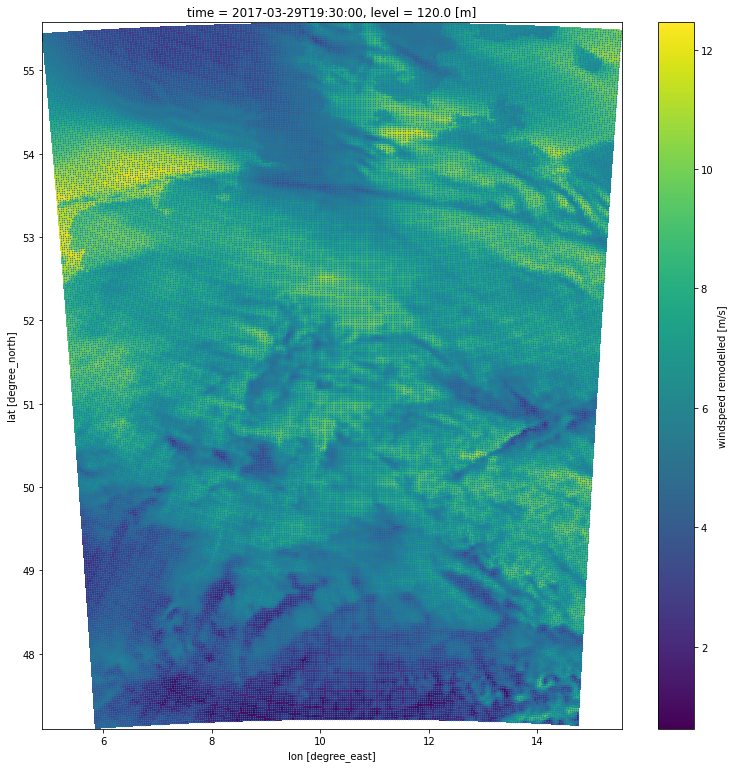

In [106]:
ds.wspd.plot(x='lon', y='lat', figsize=(13,13))
plt.scatter(ds.lon, ds.lat, s = 0.2)

<xarray.DataArray 'wspd' ()>
array(nan)
Coordinates:
    lat      float64 nan
    lon      float64 nan
    time     datetime64[ns] 2017-03-29T19:30:00
    level    float32 120.0
    x        float64 5.115e+06
    y        float64 -3.513e+06
Attributes:
    long_name:    windspeed remodelled
    description:  windspeed remodelled
    version:      D-3km.E5 Rem V2
    units:        m/s
    var_desc:     Wind Speed\n


Text(<xarray.DataArray 'lon' ()>
array(nan)
Coordinates:
    lat      float64 nan
    lon      float64 nan
    time     datetime64[ns] 2017-03-29T19:30:00
    level    float32 120.0
    x        float64 5.115e+06
    y        float64 -3.513e+06
Attributes:
    description:  LONGITUDE, WEST IS NEGATIVE
    units:        degree_east, <xarray.DataArray 'lat' ()>
array(nan)
Coordinates:
    lat      float64 nan
    lon      float64 nan
    time     datetime64[ns] 2017-03-29T19:30:00
    level    float32 120.0
    x        float64 5.115e+06
    y        float64 -3.513e+06
Attributes:
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north, 'interp')

posx and posy should be finite values
posx and posy should be finite values


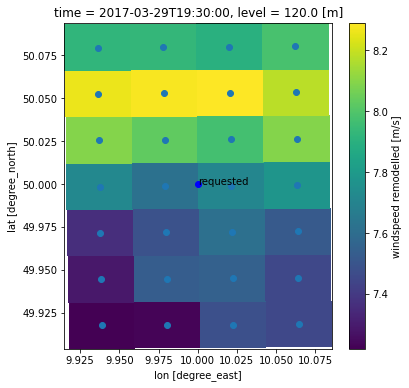

In [58]:
# A 2D plot of the SPEED variable, assigning the coordinate values,
# and plot the verticies of each point
dsplot = ds.where((lon-0.1 < data.lon) & (data.lon < lon+0.1) & (lat-0.1 < data.lat) & (data.lat < lat+0.1), drop=True)
dsplot.wspd.plot(x='lon', y='lat', figsize=(6,6))
plt.scatter(dsplot.lon, dsplot.lat)#, s = 0.2)

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(ds.lat-lat)
abslon = np.abs(ds.lon-lon)
c = np.maximum(abslon, abslat)

([yloc], [xloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
#point_ds = ds.sel(x=xloc, y=yloc)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
#plt.scatter(point_ds.lon, point_ds.lat, color='r')
#plt.text(point_ds.lon, point_ds.lat, 'nearest')

# Plot interpolation value
[x_interp,y_interp] = coor_transformation(coor=[lon,lat])
point_interp = ds.interp(x=x_interp, y=y_interp)
print(point_interp.wspd.load())
plt.scatter(point_interp.lon, point_interp.lat, color='r')
plt.text(point_interp.lon, point_interp.lat, 'interp')

# Point from projection
#x_new = abs(x/10000)
#y_new = abs(y/10000)
#print(f"x:{x}, y:{y}")
#print(f"x:{x_new}, y:{y_new}")
#coor = data.sel(x=round(x_new,0), y=round(y_new,0), level=120, time=f"{year}-03-29T19:30").wspd.load()
#print(f"lon:{coor.lon}, lat:{coor.lat}")

#plt.scatter(coor.lon, coor.lat, color='r')
#plt.text(coor.lon, coor.lat, 'same')

#plt.title('speed at nearest point: %s' % point_ds.wspd.data)

In [29]:
data.sel(x=round(x_new,0), y=round(y_new,0), level=120, time=f"{year}-03-29T19:30").wspd.load().lat

<xarray.DataArray 'lat' ()>
array(48.245087, dtype=float32)
Coordinates:
    lat      float32 48.25
    lon      float32 7.249
    time     datetime64[ns] 2017-03-29T19:30:00
    x        int16 37
    y        int16 40
    level    float32 120.0
Attributes:
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north

# 2. yearly average data

The averaged data contains wind statistics of each coordinate at a certain level. In 12 directional subclases, both the average windspeed and the dominant wind direction is given.

In [ ]:
def circularHisto(xarray, dataVariable:str, grid=False):
    '''
    To Do's:
    - Add colorbar
    '''
    radii = xarray[dataVariable].values
    N = radii.size
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    width = np.full((1, 12), 2 * np.pi / 13)[0]
    
    ax = plt.subplot(111, projection='polar')
    bars = ax.bar(theta, radii, bottom=0.0, width=width)
    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.viridis(r / radii.max()))
        bar.set_alpha(0.7)

    ax.set_theta_zero_location("N")
    if grid:
        ax.set_rticks(np.arange(0,radii.max(),2))
    else:
        ax.set_rticks([])
    
    ticks = ["N","NW","W","SW","S","SE","E","NE"]
    ax.set_xticklabels(ticks)
    
    if dataVariable == "wspd":
        ax.set_title("Average Windspeed [m/s] 2008 - 2017", pad=25)
        
    if dataVariable == "histo":
        ax.set_title("Distribution of wind directions 2008 - 2017", pad=25)
    plt.show()
    
def describingHisto(xarray):
    fig, axs = plt.subplots(1, 2)
    
    diags =("histo","wspd")
    
    for num, ax in enumerate(axs):
        ax = circularHisto(xarray, dataVariable=diags[num])

In [ ]:
path = r"windData/D-3km.E5.dirStats.140m.2008-2017.nc"

data120m = xr.open_dataset(path)
data120m

In [ ]:
point = {
    "level":114,
    "y":0,
    "x":0,
    "coor":[50,10],
    "time":pd.to_datetime(["2016-05-01"])
}

start = timeit.default_timer()

([yloc], [xloc]), nlevel  = findPoint(data120m, point)

mid = timeit.default_timer()

point_stat = getPointData(xarray=data120m, x=xloc, y=yloc)

end = timeit.default_timer()

point["x"] = xloc
point["y"] = yloc

print(f'Nearest point: {point["x"]},{point["y"]}')
print(f'Nearest point coordinates: {point_stat.lon.values},{point_stat.lat.values}')
print(f'Time to find nearest point: {mid - start}')
print(f'Time to find get point data: {end - mid}')

point_stat

In [ ]:
circularHisto(point_stat, dataVariable="histo")
circularHisto(point_stat, dataVariable="wspd", grid=True)

In [ ]:
import numpy as np
import numba
from numba import cuda, f8, uint8

n = 20
dk = 0.00001

In [ ]:

def frange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit frange()


In [ ]:
@numba.jit(nopython=True)
def farange(n=n, dk =dk):
    dk = dk
    #X = np.arange(dk, n, dk)
    outerSum = 0
    for i in np.arange(dk, n, dk):
        outerSum += i

%timeit farange()

In [ ]:
@numba.jit(nopython=True)
def nbrange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit nbrange()

In [ ]:
@cuda.jit(argtypes=[f8, uint8])
def cudarange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit cudarange()